# Instructions

1. Download the provided jupyter notebook file to your computer.
2. Write all your answers and code into this notebook file.
3. When your work is completed, export your notebook to an HTML file.
4. Submit your HTML file and a copy of the notebook to the assignment page on Moodle.



## Identification

### Your Information

Your Last Name: Siddique

Your First Name: Muhammad Saad


### Group Members (list any classmates you worked with on this problem set)

Your Group Members:

# Textbook Reading

The two required readings for this week are textbook chapters relating to decision trees.

1. ISLP - Chapter 8, Introduction and Section 8.1. This provides useful background on the theory behind decision trees.
2. Géron - Chapter 6. A guide on implementing Decision Trees in `sklearn`. 

You should complete both of these readings in their entireties. 

There are also two optional readings for the week.

1. Martin, A., Quinn, K., Ruger, T., & Kim, P. (2004). - "Competing Approaches to Predicting Supreme Court Decision Making." Perspectives on Politics, 2(4), 761-767. This article uses classification trees to estimate how justices may rule on upcoming cases and compares the performance of their model to expert predictions. The application also demonstrates the interpretability of simple decision trees.
2. Loh, Wei‐Yin. "Classification and regression trees." Wiley interdisciplinary reviews: data mining and knowledge discovery 1.1 (2011): 14-23. This reading provides some extra examples of the theory behind classification trees. It also introduces and compares some of the different algorithms for fitting trees.




# Predicting Educational Achievement in Portugal

This problem draws upon results from the following paper on educational outcomes.

Cortez, Paulo, and Alice Maria Gonçalves Silva. "Using data mining to predict secondary school student performance." (2008)

The authors collected and evaluated data from two Portuguese secondary schools on a range of student attributes and performance outcomes. In this problem, you will analyze a subset of this data which is provided in the `students.csv` file. A full description of the variables is provided in the `student_characteristics.png` file.

In [162]:
school['Medu'].unique()

array([4, 1, 3, 2, 0])

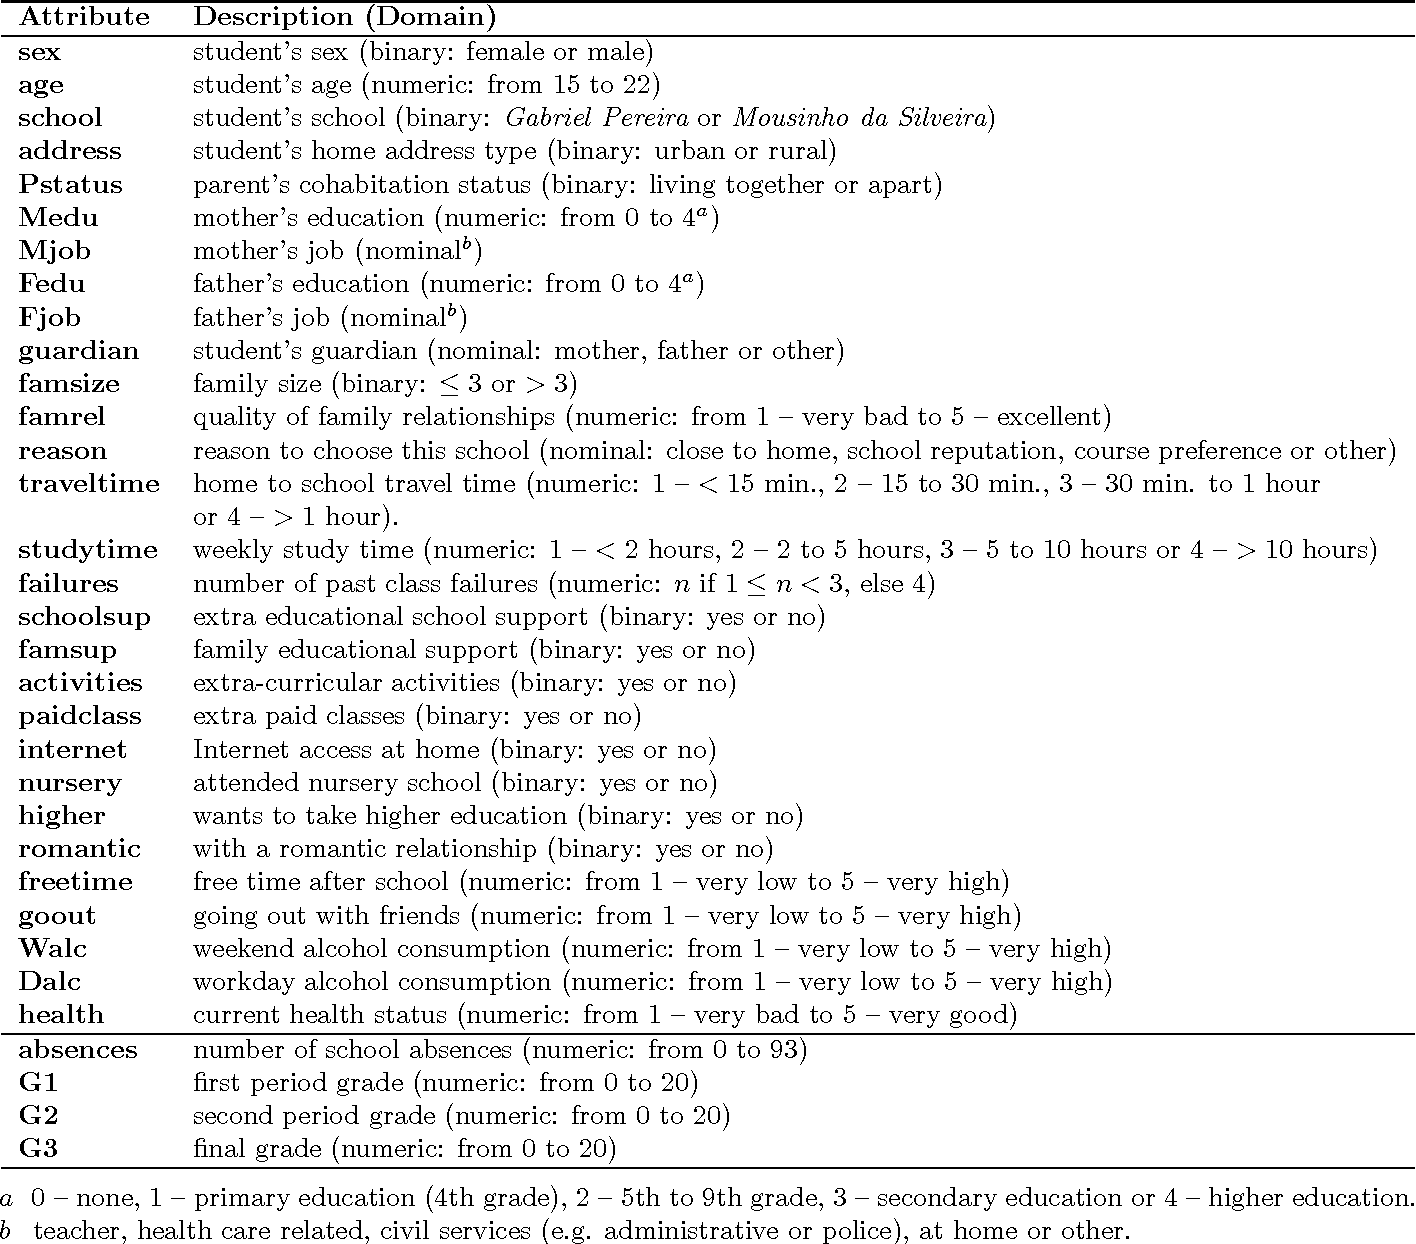

In [163]:
from PIL import Image
Image.open("student_characteristics.png")

Our outcome of interest will be the variable `G3`, which reports the student's final language score. Earlier period grades `G1` and `G2` should be dropped for the following analysis.

In [164]:
# Standard Packages
import numpy as np
import pandas as pd

# sklearn packages for model fitting and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

# Loading in trees and their functionality
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
# Packages for visualizing the tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text

# Plotting
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from plotnine import *



## Pre-processing the Data

After reading in the data, inspect the list of variables and the associated data type each column has. Several of the columns may need to be transformed into categorical / dummy variables. 

Based on the above variable descriptions and your data exploration, identify and convert columns you think should be saved in a different format.

Note: The pandas function `pd.get_dummies()` or the sklearn `ColumnTransformer` and `OneHotEncoder` functions may be helpful here.

In [165]:
# Your code here:
school = pd.read_csv('students.csv')
school.dtypes


school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

In [166]:
school['school'].value_counts()

school
GP    423
MS    226
Name: count, dtype: int64

In [167]:
school[numeric_cols].nunique().sum() -  len(numeric_cols)

np.int64(71)

In [168]:
categorical_cols = [
    'school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 
    'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 
    'nursery', 'higher', 'internet', 'romantic'
]

numeric_cols = [
    'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
    'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'
]


school_intial_x = school[categorical_cols + numeric_cols]
school_y = school['G3']

school_x = pd.get_dummies(school_intial_x, columns=categorical_cols, drop_first=True)
school_x.shape

(649, 39)

In [169]:
# Code to check if we have the right no of variables in the dataset after conversion
school[categorical_cols].nunique().sum() - len(categorical_cols) + len(numeric_cols)

np.int64(39)

In [170]:
school_x['school_MS'].sum()

np.int64(226)

## Fitting a Basic Decision Tree

Fit a basic decision tree to predict `G3` using all other available variables (excluding `G1` and `G2`). Follow these steps:

1. Split the data into training and testing sets, using `random_state=422`, and set the testing size to 30% of the total observations
2. Set the `max_depth` of your tree to 1 
3. Report which variable is used for the initial split
4. Report the RMSE for predictions from this fitted tree on the testing data. Interpret and evaluate your results.

In [171]:
# Your code here:
X_train, X_test, y_train, y_test = train_test_split(school_x, school_y, test_size=0.3, random_state=422)
school_tree = DecisionTreeRegressor(max_depth=1)
school_tree.fit(X_train, y_train)

# Printing the tree text
school_text = export_text(school_tree, 
                        feature_names=list(X_train.columns)
                        )
print(school_text)
dt_y_pred = school_tree.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE for the decision tree with depth 1 is {round(dt_rmse, 2)}')

|--- failures <= 0.50
|   |--- value: [12.53]
|--- failures >  0.50
|   |--- value: [8.53]

RMSE for the decision tree with depth 1 is 2.83


Use failure to make the first split at threshold of 0.5. RMSE for the decision tree is 2.83 which means that on average the predictions are 2.83 grades away from the actual grade on a scale from 0-20

## Fitting an OLS Model

Using the same training / testing split as above, fit an ordinary least squares (OLS) [regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to the training set, predicting `G3` using all other variables (again excluding `G1` and `G2`). Report the RMSE for predictions from this model on the testing data. How does the error of your OLS model compare to the tree model?

In [172]:
# Your code here:
from sklearn.linear_model import LinearRegression

# sklearn doesn't call it OLS, but it's the same thing
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_pred = ols.predict(X_test)

ols_rms = np.sqrt(mean_squared_error(y_true=y_test , y_pred=ols_pred))
print(f'RMSE for the OLS is {round(ols_rms, 2)}')

RMSE for the OLS is 2.71


The ols root mean squared error is relatively lower than decision tree

In [173]:
# How do I check if these two points are statistically differnet
# se_ols = (y_test - ols_pred)**2
# se_dt = (y_test - dt_y_pred)**2


## Recreating the Decision Tree with OLS

Run a linear regression on your data that will produce the same predicted values as your basic decision tree of depth 1 fit above.

Discuss how confident should we be with the estimated uncertainty in this model.

In [174]:
# Your code here:
import statsmodels.formula.api as smf
dt_ols = pd.concat([X_train , y_train], axis=1)
dt_ols['failure_dummy']= dt_ols['failures'] <=0.5

dt_ols_reg = smf.ols('G3 ~ failure_dummy' , data = dt_ols).fit()
dt_ols_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     109.8
Date:                Mon, 02 Feb 2026   Prob (F-statistic):           3.81e-23
Time:                        22:44:55   Log-Likelihood:                -1132.7
No. Observations:                 454   AIC:                             2269.
Df Residuals:                     452   BIC:                             2278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.5286      0.351     24.276      0.000       7.838       9.219
failure_dummy[T.True]     4.0027      0.382     10.478      0.000       3.252       4.753
==============================================================================
Omnibus:                       97.759   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.821
Skew:                          -1.039   Prob(JB):                     5.15e-58
Kurtosis:                       6.103   Cond. No.                         4.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Fitting a LASSO Model

Using the same training / testing split as above, fit a LASSO Model with cross-validation with the [LassoCV()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) function. Use `random_state=0` and use the default 5-fold cross-validation (set `cv=5` or leave this argument blank). Report the RMSE from this model on the testing data and compare it to the OLS fit.

In [175]:
# Your code here:
from sklearn.linear_model import LassoCV
mod_lasso = LassoCV(cv=10, random_state=0).fit(X_train, y_train)
lasso_pred = mod_lasso.predict(X_test)

lasso_rmse = np.sqrt(mean_squared_error(y_true=y_test , y_pred=lasso_pred))
print(f'RMSE for the LASSO is {round(lasso_rmse, 2)}')

RMSE for the LASSO is 2.64


In [176]:
print(f"number of predictors used by LASSO: {np.sum(mod_lasso.coef_ != 0)}")
lasso_coefs = pd.Series(
    mod_lasso.coef_,
    index=X_train.columns
)
lasso_coefs

number of predictors used by LASSO: 27


age                  0.148254
Medu                 0.000000
Fedu                 0.129431
traveltime           0.000000
studytime            0.450166
failures            -1.549993
famrel               0.168588
freetime            -0.157110
goout                0.077195
Dalc                -0.197954
Walc                -0.062373
health              -0.172075
absences            -0.030642
school_MS           -1.395008
sex_M               -0.385157
address_U            0.457498
famsize_LE3          0.078018
Pstatus_T            0.000000
Mjob_health          0.000000
Mjob_other          -0.282715
Mjob_services        0.000000
Mjob_teacher         0.022297
Fjob_health          0.000000
Fjob_other          -0.000000
Fjob_services       -0.299637
Fjob_teacher         0.000000
reason_home         -0.000000
reason_other        -0.046623
reason_reputation    0.096389
guardian_mother     -0.449342
guardian_other       0.000000
schoolsup_yes       -0.972751
famsup_yes           0.000000
paid_yes  

## Fitting Trees with Greater Depth

1. Using the same training / testing split as above, fit a decision tree for a range of `max_depth` arguments from 1 to 15
2. Report which depth tree produces the smallest RMSE in the testing data and report the value of this RMSE
3. Plot the decision tree identified in Step 2
4. Describe how the best selected decision tree's predictions compare to the OLS predictions
5. Create a plot with the true values of the `G3` score in the testing data on the x-axis and the predicted values from the best model identified in Step 2 on the y-axis. Comment on any patterns in this plot.

In [177]:
# Your code here:
depth = list(range(1, 16))
rmse_dt_array = []
for i in depth:
    school_tree = DecisionTreeRegressor(max_depth=i)
    school_tree.fit(X_train, y_train)
    dt_y_pred = school_tree.predict(X_test)
    rmse_dt_array.append(np.sqrt(mean_squared_error(y_true=y_test , y_pred=dt_y_pred)))

In [178]:
# Part 2:
depth[np.argmin(rmse_dt_array)]

3

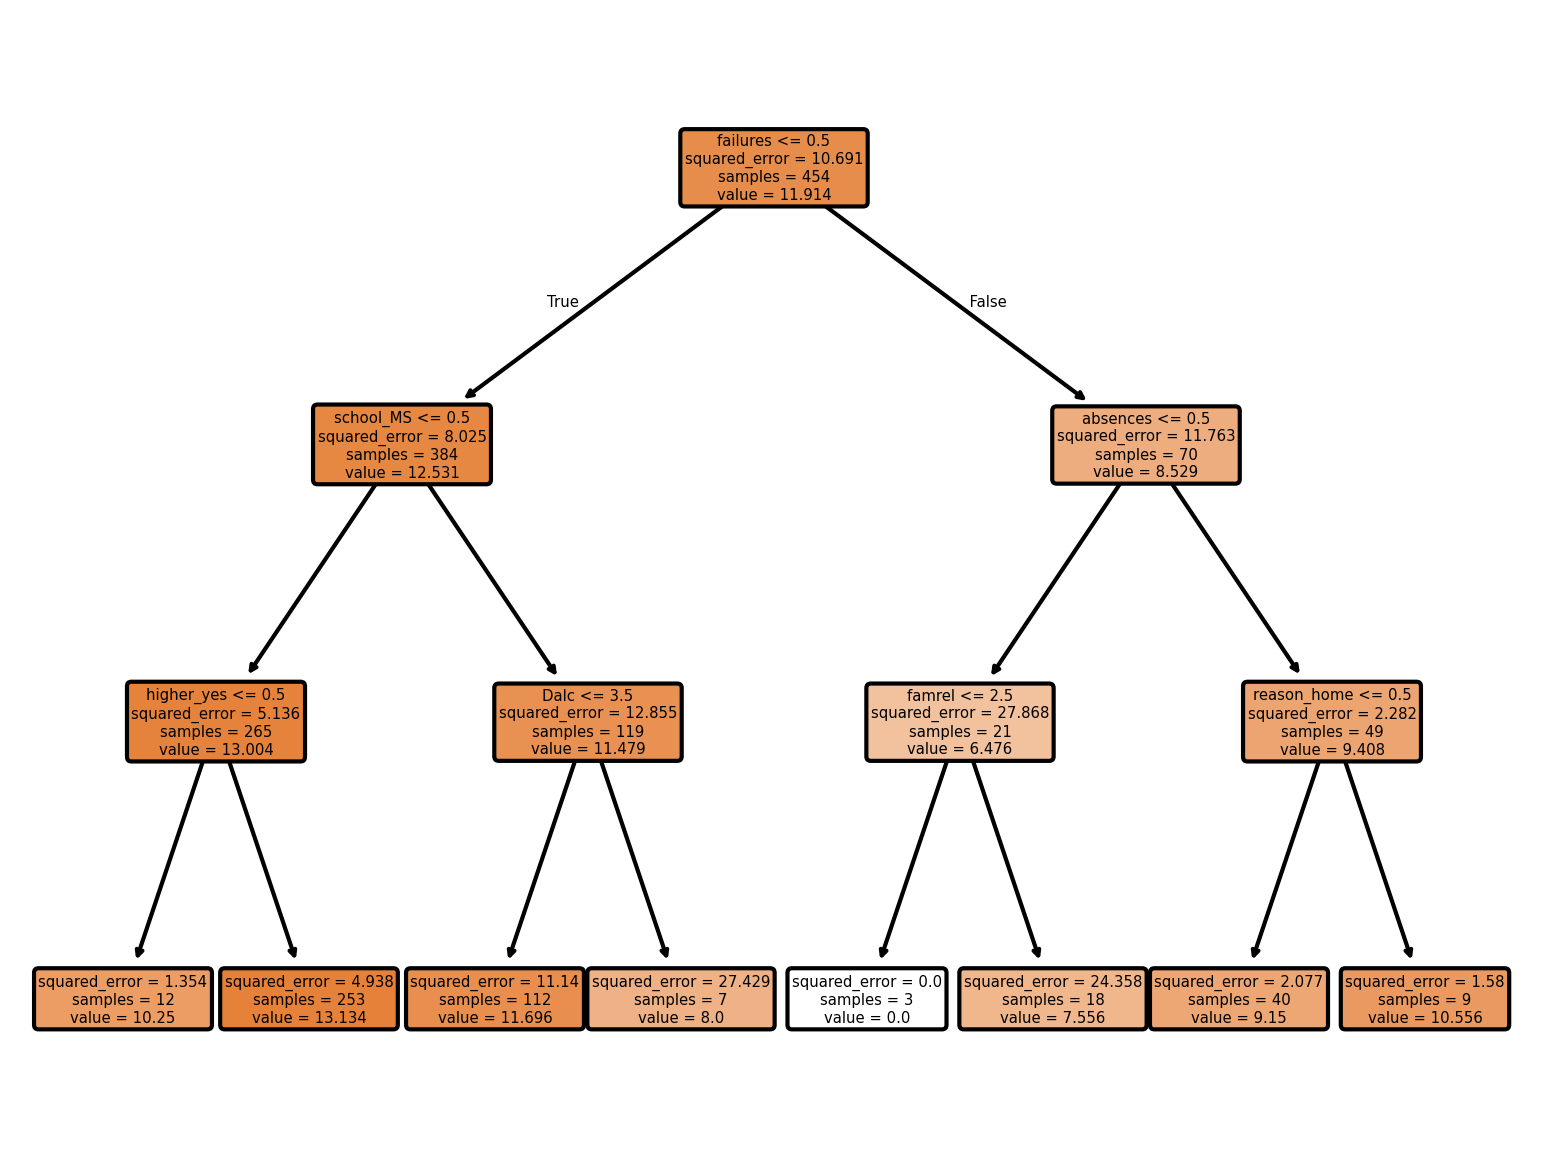

In [179]:
# Part 3
optimal_tree = DecisionTreeRegressor(max_depth=3)
optimal_tree.fit(X_train, y_train)
optimal_tree_y_pred = optimal_tree.predict(X_test)

list(y_train.astype('str').unique())
plt.figure(dpi=300) # Changing the resolution of our plot
plot_tree(optimal_tree, filled=True, feature_names=X_train.columns,
          class_names=list(y_train.astype('str').unique()),
          rounded=True)
plt.show()

In [180]:
# part 4
print(f'RMSE for decision tree is {rmse_dt_array[np.argmin(rmse_dt_array)]}')
print(f'RMSE for OLS is {ols_rms}')

RMSE for decision tree is 2.7131012232748652
RMSE for OLS is 2.714366443155578


For the optimal decision tree of depth 3, it is the upto 2 decimal point highlighting that even the optimal deicsion tree is not outperforming the ols regression

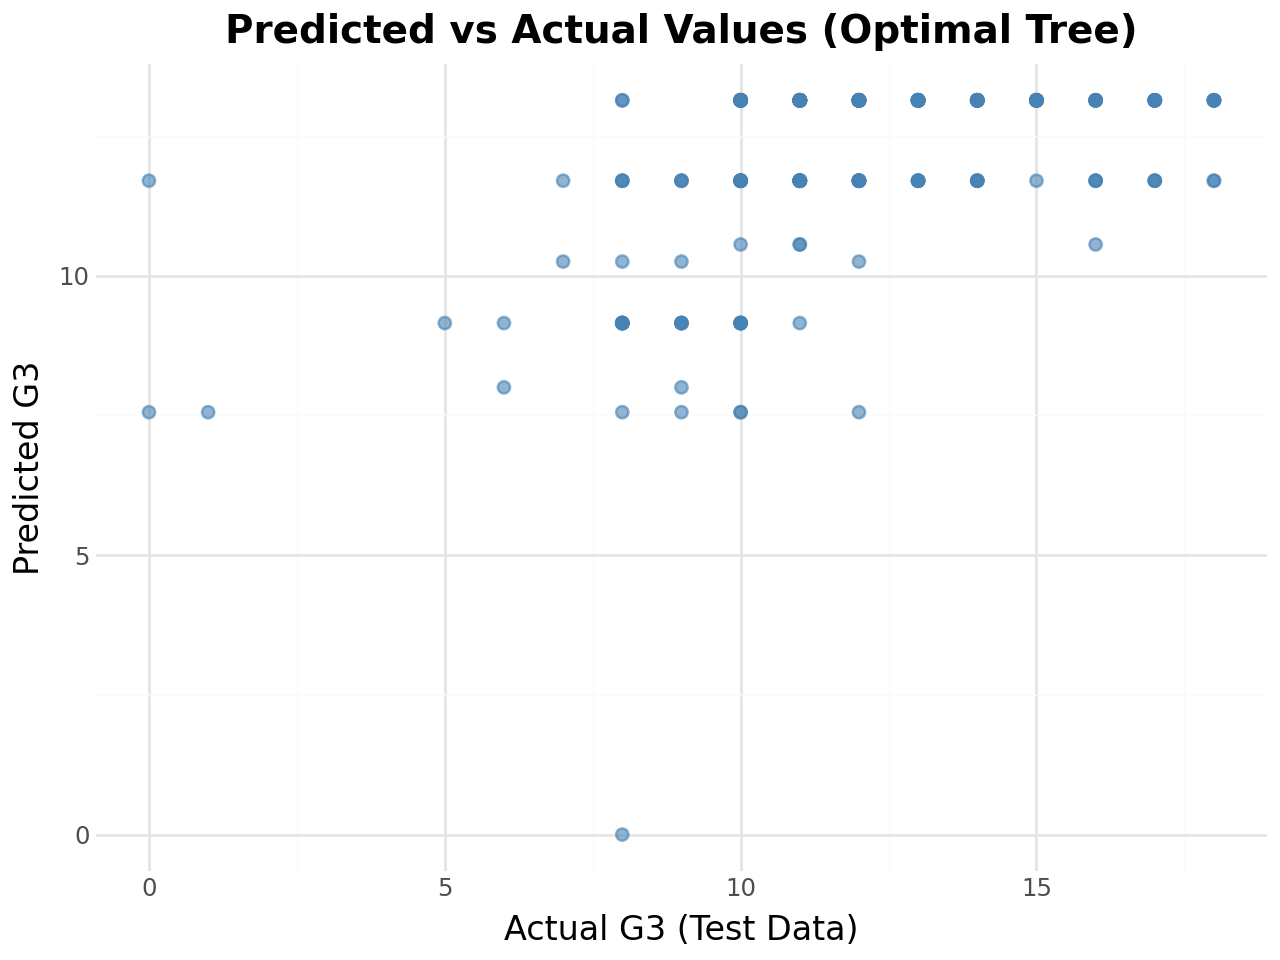

In [181]:
from plotnine import *

plot_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted': optimal_tree_y_pred
})

# Create the ggplot
(ggplot(plot_data, aes(x='Actual', y='Predicted'))
 + geom_point(alpha=0.6, color='steelblue', size=2)
#  + geom_abline(intercept=0, slope=1, color='red', linetype='dashed', size=1)
 + labs(
     title='Predicted vs Actual Values (Optimal Tree)',
     x='Actual G3 (Test Data)',
     y='Predicted G3'
 )
 + theme_minimal()
 + theme(
     plot_title=element_text(size=14, face='bold'),
     axis_title=element_text(size=12)
 )
)


In [182]:
correlation = np.corrcoef(y_test, optimal_tree_y_pred)[0, 1]
print(correlation)

0.5033173542605165


as the avlue for actual data increase the value for the predicted data also increase showing a positive corealtion of 0.5

## Cross-Validation and GridSearchCV

Your above code varied the parameter of `max_depth` in forming the tree, but that is not the only parameter available to calibrate tree models and attempt to avoid overfitting. The `max_leaf_nodes` parameter determines the total number of final nodes in the model (which may not be equal to the tree depth if further splitting only occurs along one path of the tree).

We can use cross-validation within our training sample to test a range of tree fitting parameters to see which generate the best fit. Read about [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and its [User Guide](https://scikit-learn.org/stable/modules/grid_search.html#grid-search). This function allows you to specify multiple parameters to test (which could otherwise be accomplished with a nested for-loop).

Use this function to optimize your decision tree over both the `max_depth` and `max_leaf_nodes` parameters and report your results. How does the accuracy of this model in the testing data compare to your earlier models?

1. Test `max_depth` in a range from 1-20
2. Test `max_leaf_nodes` in a range of 2-40
3. Use `cv=5` parameter in the `GridSearchCV()` function to conduct 5-fold cross-validation
4. Set `scoring="neg_mean_squared_error"` to have the function optimize to find the smallest MSE

After running the grid search, report the best parameters you identified and re-fit a tree using these parameters. Report the RMSE in the testing data and plot the tree.

Note, this grid search may take a single-digit number of minutes to run.

In [183]:
# Your code here:
tree_parameters = {
    'max_depth': range(1, 20+1),
    'max_leaf_nodes': range(2, 40+1) ,
    'criterion': ['squared_error', 'friedman_mse']
}

tree_gs = DecisionTreeRegressor()

grid_search = GridSearchCV(tree_gs, param_grid=tree_parameters, cv=5, 
                           scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

,estimator,DecisionTreeRegressor()
,param_grid,"{'criterion': ['squared_error', 'friedman_mse'], 'max_depth': range(1, 21), 'max_leaf_nodes': range(2, 41)}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [184]:
# The best parameters are stored in the grid_search object
print(grid_search.best_params_)
# We can also extract the associated best accuracy score
print(grid_search.best_score_)

{'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 4}
-8.36141708355271


## Fitting regression tree with the best parameter

In [185]:
optimal_reg_decision_tree = DecisionTreeRegressor(max_depth=2 , max_leaf_nodes=4, criterion='squared_error')
optimal_reg_decision_tree.fit(X_train , y_train)
optimal_reg_decision_tree_y_pred = optimal_reg_decision_tree.predict(X_test)

optimal_reg_decision_tree_rmse = np.sqrt(mean_squared_error(y_true=y_test , y_pred=optimal_reg_decision_tree_y_pred))
optimal_reg_decision_tree_rmse

np.float64(2.7661778653328946)

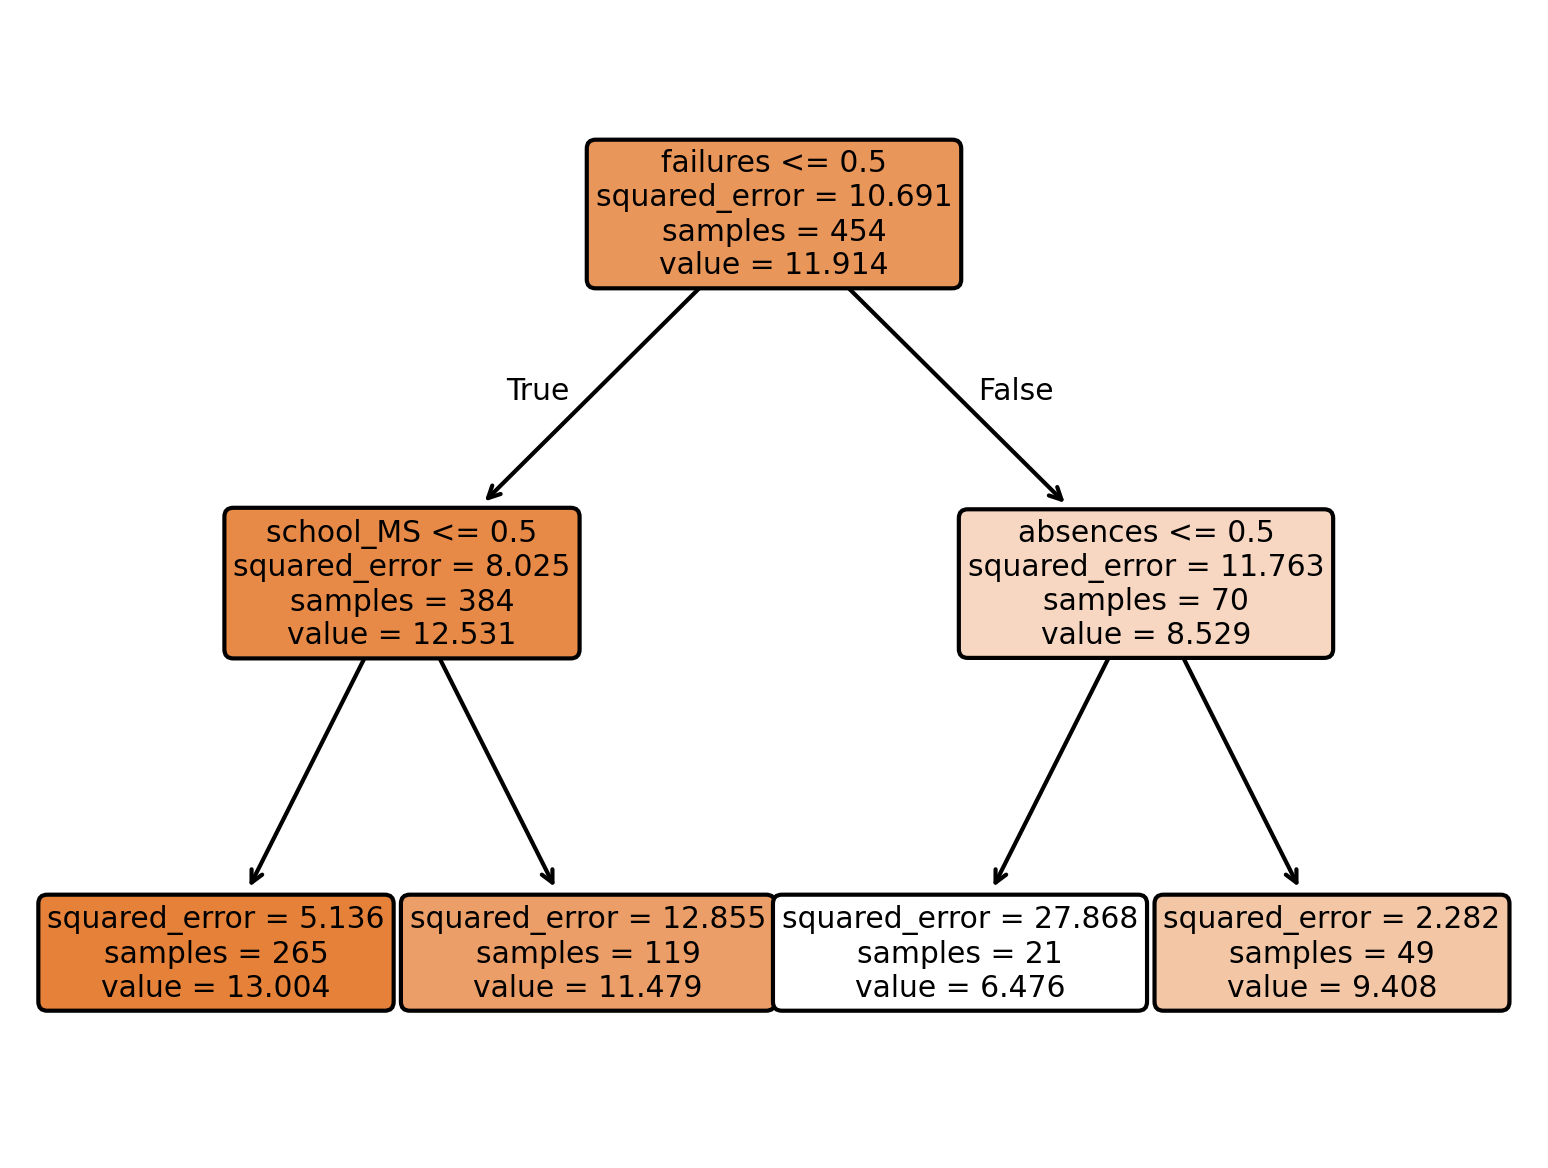

In [186]:
#Plotting the tree
plt.figure(dpi=300) # Changing the resolution of our plot
plot_tree(optimal_reg_decision_tree, filled=True, feature_names=X_train.columns,
          class_names=list(y_train.astype('str').unique()),
          rounded=True)
plt.show()

## Decision Tree With Cost Complexity Pruning (OPTIONAL)

Another way to prevent a tree from overfitting is with cost-complexity pruning. This method first fits a large tree (perhaps a full tree to the data with no restrictions). It then begins at the bottom of the true and eliminates leaf nodes that do not add significant explanatory power (this processes is called _pruning_ or _pruning back_ the tree). 

This process is attractive because by initially growing a tree to full length, we can identify pairs of sequential splits that provide large increases in predictive performance that would be missed if we used a top-down approach that only looked at the performance gain from each step. Following this up by pruning away the less important branches can still adjust the tree to minimize overfitting.

### Growing an unrestricted tree

First, fit a tree with no restrictions on depth to the training data. Report the RMSE from this tree in both the training and testing data sets and comment on the results. You can do this by setting the `max_depth=None` argument or omitting this parameter altogether.

In [187]:
# Your code here:

### Pruning the tree

Once grown this tree can be _pruned_, which will eliminate some of the nodes. Read the documentation for the cost-complexity pruning [here](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html). Implement this procedure to your decision tree using 5-fold cross-validation to determine the optimal cost-complexity pruning alpha value. Then fit a new decision tree on the training data where you pass this optimal value to  the `ccp_alpha` argument. Report the RMSE in the testing data for this tree and plot the tree itself.

In [188]:
# Your code here:

## Comparing Various Models

This question asks you to compare your above results for four different models.

1. The OLS model
2. The LASSO model
3. The optimal decision tree chosen through the GridSearchCV()
4. The optimal decision tree chosen through cost-complexity pruning (OPTIONAL)

For each model, fill out the below table reporting both the MSE in the testing data and the number of features needed to make predictions. 

After completing this table, and including any other factors you consider relevant, which model would you use to estimate student grades? Justify your decision.

|    Model                      | Testing MSE | Features Needed for Prediction |
|---------------                  | ------------- | ---------- |
| OLS                                        |    2.71           |    39        |
| LASSO                                      |     2.64          |      27      |
| GridSearch Tree                            |     2.76          |     3       |
| Cost-complexity Pruning Tree (OPTIONAL)    |               |            |

I would use the GridSearch Tree. Although it provides the lowest MSE, it is only marginally better than LASSO and OLS and uses only three features, which are very easy to capture: failures, school_MS, and absences.

- Failures represents the number of past class failures.  
- school_MS is a dummy variable that takes the value 1 when the student attended Moushino Da Silveria school.
- Absences represents the number of school absences.

All these variables are easy to obtain. In contrast, LASSO and OLS require additional features that are extremely difficult to measure, such as alcohol consumption or romantic relationships. Even after reducing variables from 39 to 27, LASSO still includes features prone to measurement error.

This makes the GridSearch Tree the preferred choice, as it provides almost the same MSE on the test set but relies on easily measurable variables. Although GridSearch Tree is computationally heavier and takes more time to execute, the simplicity and reliability of its variables make it the model I would choose.

# Predicting the Heart Data From Lecture

In recent classes we have worked with the `heart` data to try to predict the presence of heart disease. So far we have fit our models using default metrics of overall accuracy to select our hyperparameters (e.g. the `k` in a k-NN model or depth of decision trees).

There is no reason we have to rely on this default accuracy for this "hyperparameter tuning" process. Fit and tune a decision tree model to this heart data to optimize f1-score. If you need to specify a random state, set it as 422. 

Did your decision tree change at all relative to what was fit in class?

In [189]:
# Your code here
heart_data= pd.read_csv('heart_data.csv')

In [190]:
heart_data.drop(columns=['Unnamed: 0'], axis = 1 , inplace = True)
heart_data.dropna(inplace=True)

In [191]:
y_heart = heart_data['y']
x_heart = heart_data.drop(columns=['y'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(x_heart, y_heart, test_size=0.3, random_state=422)

In [199]:
param_grid = {
    'max_depth': range(1, 20+1),
    'max_leaf_nodes': range(2, 40+1) ,
    'criterion': ['gini', 'entropy']
}

heart_decision_tree = DecisionTreeClassifier()
grid_search_heart_disease = GridSearchCV(heart_decision_tree , param_grid = param_grid , cv=5, scoring='f1')
grid_search_heart_disease.fit(X_train, y_train)

,estimator,DecisionTreeClassifier()
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': range(1, 21), 'max_leaf_nodes': range(2, 41)}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [200]:
# The best parameters are stored in the grid_search object
print(grid_search_heart_disease.best_params_)
# We can also extract the associated best accuracy score
print(grid_search_heart_disease.best_score_)

{'criterion': 'gini', 'max_depth': 11, 'max_leaf_nodes': 24}
0.7674538050903289


In [204]:
#Plotting the tree
heart_disease_f1_optimal = DecisionTreeClassifier(max_depth=11, max_leaf_nodes=24 , criterion='gini')
heart_disease_f1_optimal.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,11
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,24
,min_impurity_decrease,0.0
,class_weight,None


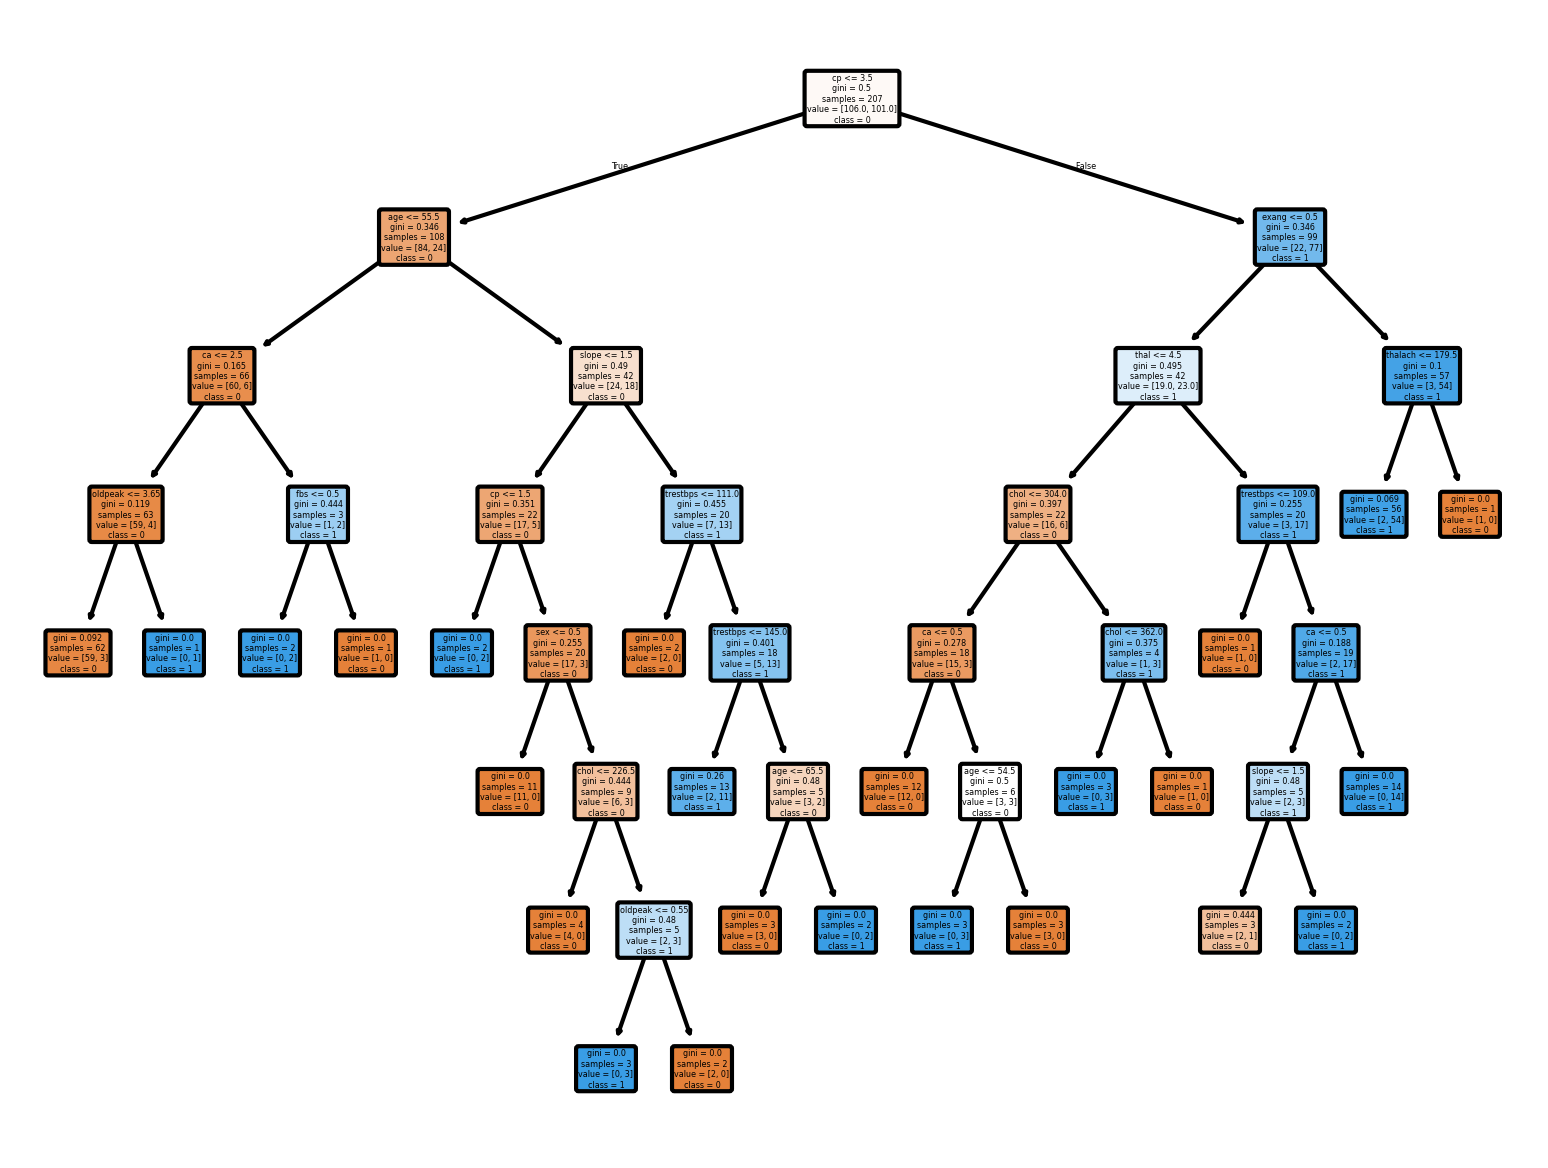

In [205]:
#Plotting the tree
plt.figure(dpi=300) # Changing the resolution of our plot
plot_tree(heart_disease_f1_optimal, filled=True, feature_names=X_train.columns,
          class_names=list(y_train.astype('str').unique()),
          rounded=True)
plt.show()

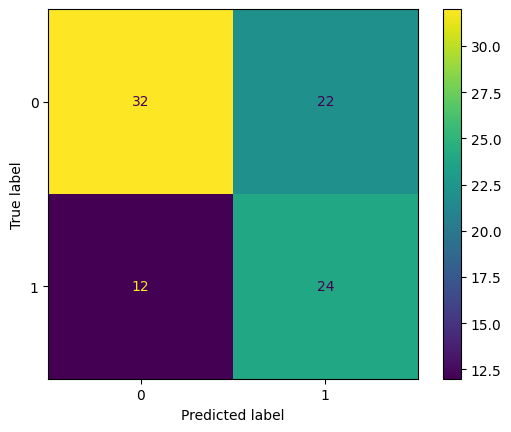

In [207]:
# Confusion matrix for the Grid Search Tree
cm_tree_gs = confusion_matrix(y_true=y_test, y_pred=heart_disease_f1_optimal.predict(X_test))
ConfusionMatrixDisplay(cm_tree_gs).plot()

In [208]:
f1 = f1_score(y_test, heart_disease_f1_optimal.predict(X_test))
print("F1 score:", f1)

F1 score: 0.5853658536585366
